## Make the four panel $\sigma_{in}$, $\sigma_{out}$ plot

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.


/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_93064/3127109696.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df[key] = torch.tensor(value)


NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
YES WE

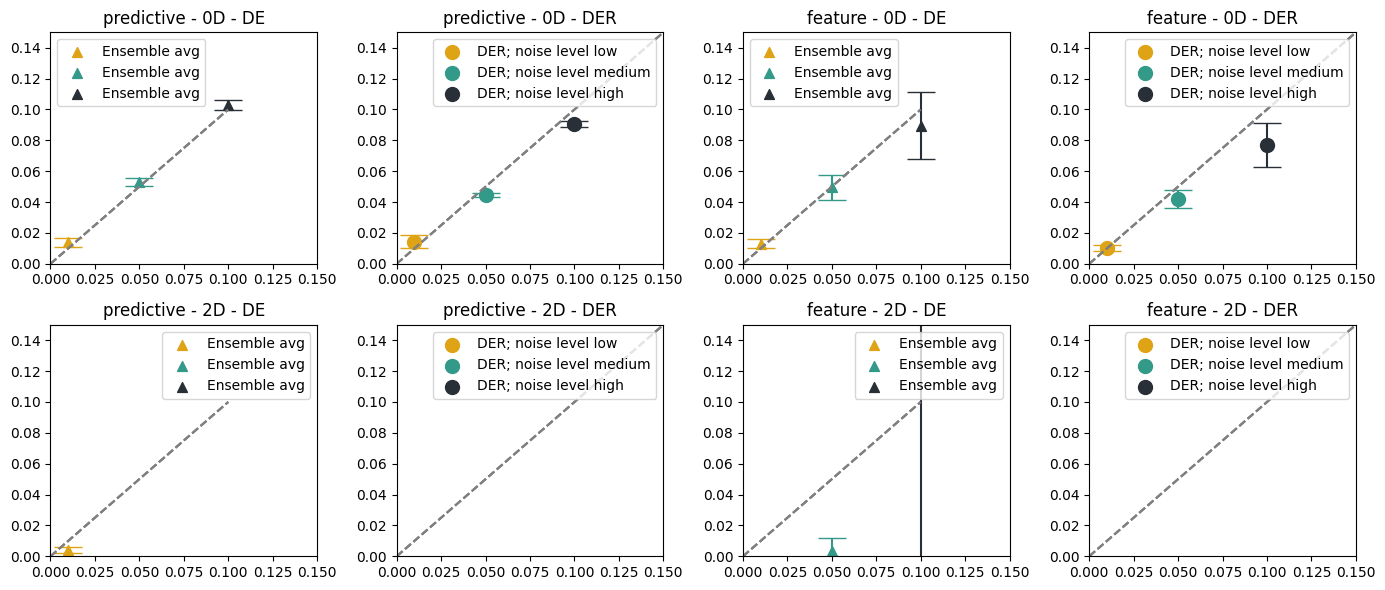

In [5]:
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]
# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#292F36"]
size_df_linear = 1000
size_df_image = 10000
epoch = 99
ensemble = True
n_models = 5
fig, axes = plt.subplots(2, 4, figsize=(14, 6))  
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}

# Iterate over the combinations of the two lists
for j, dim in enumerate(data_dim_list):
    for i, inject_type in enumerate(inject_type_list):
        
        # first go through the two different model types
        for m, model in enumerate(model_type):
            ax = axes[index]
            ax.set_title(f'{inject_type} - {dim} - {model}')
            index += 1
            for n, noise in enumerate(noise_list):
                
                # make the test set
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df_linear)
                    if inject_type == "feature":
                        data.simulate_data(
                            data.params,
                            noise,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                            vary_sigma=True,
                        )
                    else:
                        sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                        data.simulate_data(
                            data.params,
                            sigma,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                        )
                    df_array = data.get_dict()
                    # Convert non-tensor entries to tensors
                    df = {}
                    for key, value in df_array.items():
                
                        if isinstance(value, TensorDataset):
                            # Keep tensors as they are
                            df[key] = value
                        else:
                            # Convert lists to tensors
                            df[key] = torch.tensor(value)
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    sigma = DataPreparation.get_sigma(
                        noise, inject_type=inject_type, data_dimension=dim)
                    data.sample_params_from_prior(
                        size_df_image,
                        low=[0, 1, -1.5],
                        high=[0.5, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df_image,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                x_test = model_inputs
                y_test = model_outputs
                
                # print(f"dim is {dim}, noise is {noise}, sigma is {sigma}, inject is {inject_type}")
                path = "../DeepUQResources/checkpoints/"
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                    loss = "DER"
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    if dim == "0D":
                        file_name += f"_sizedf_{size_df_linear}"
                    elif dim == "2D":
                        file_name += f"_sizedf_{size_df_image}"
                    file_name += ".pt"
                    try:
                        chk = torch.load(file_name, map_location=DEVICE)
                    except FileNotFoundError:
                        print("cannot find this model", file_name)
                        continue
                    # define the model at this epoch
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                    # checkpoint['model_state_dict'])
                    setupmodel.eval()

                    y_pred = setupmodel(
                        torch.Tensor(x_test
                            )
                        ).detach().numpy()
                    #print(f'model = {model}, inject = {inject_type}, dim = {dim}, noise = {noise}') 
                    #print('DER this is the mean true value', np.mean(x_test))
                    #print('this is the mean predicted value', np.mean(y_pred[:, 0]))
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(
                        abs(
                        beta
                        * (1 + nu)
                        / (alpha * nu)
                        )
                    )
                    #print('this is the mean u_al value', np.mean(u_al))
                    # now standardize the output uncertainty
                    # _, u_al_denormed = denormalize(x_test, u_al, chk.get("norm_params"))
                    ax.errorbar(
                            sigma_y_lookup[noise],
                            np.mean(u_al),
                            yerr = np.std(u_al),
                            color=color_list[n],
                            capsize=10
                        )
                    ax.scatter(
                            sigma_y_lookup[noise],
                            np.mean(u_al),
                            color=color_list[n],
                            label=f"DER; noise level {noise}",
                            s=100
                        )
                    ax.plot([0,10], [0,10], color='grey', ls='--')  
                elif model == "DE":
                    loss = "bnll_loss"
                    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
                    BETA = 0.5
                    u_al_list = []
                    for m in range(n_models):
                        file_name = (
                            str(path) +
                            f"{model}_{prescription}_{inject_type}_{dim}"
                            f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
                        )
                        if dim == "0D":
                            file_name += f"_sizedf_{size_df_linear}"
                        elif dim == "2D":
                            file_name += f"_sizedf_{size_df_image}"
                        file_name += ".pt"
                        try:
                            chk = torch.load(file_name, map_location=DEVICE)
                        except FileNotFoundError:
                            print("cannot find this model", file_name)
                            continue
                        # define the model at this epoch
                        setupmodel.load_state_dict(chk.get("model_state_dict"))
                        # checkpoint['model_state_dict'])
                        setupmodel.eval()
                        y_pred = setupmodel(
                            torch.Tensor(x_test
                                )
                            ).detach().numpy()
                        #print(f'prediction for ensemble {m}') # {y_pred}')
                        #print(f'model = {model}, inject = {inject_type}, dim = {dim}, noise = {noise}') 
                        #print('DE this is the mean true value', np.mean(x_test))
                        #print('this is the mean predicted value', np.mean(y_pred[:, 0]))
                        u_al = np.sqrt(y_pred[:, 1])
                        u_al_list.append(u_al)
                        #print('this is the mean y_pred[:, 1] so variance', np.mean(y_pred[:, 1]))
                        #print('this is the mean u_al value', np.mean(u_al))

                        '''
                        if m == 0:
                            ax.errorbar(
                                sigma_y_lookup[noise],
                                np.mean(u_al),
                                yerr = np.std(u_al),
                                color=color_list[n],
                                capsize=10
                            )
                            ax.scatter(
                                    sigma_y_lookup[noise],
                                    np.mean(u_al),
                                    color=color_list[n],
                                    label=f"MVE",
                                    s=50,
                                    marker="^"
                                )
                        '''
                        '''
                        else:
                            ax.scatter(
                                    sigma_y_lookup[noise],
                                    np.mean(u_al),
                                    color=color_list[n],
                                    s=50,
                                    marker="^"
                                )
                        '''
                    ax.errorbar(sigma_y_lookup[noise],
                                np.mean(u_al_list),
                                yerr=np.std(u_al_list),
                                color=color_list[n],
                                #alpha=0.5,
                                capsize=10                                
                                )
                    ax.scatter(sigma_y_lookup[noise],
                                np.mean(u_al_list),
                                color=color_list[n],
                                #alpha=0.5,
                                label=f"Ensemble avg",
                                s=50,
                                marker="^"
                              )
                    ax.plot([0,0.1], [0,0.1], color='grey', ls='--')
                    
                
                    
                ax.legend()
                ax.set_xlim([0,0.15])
                ax.set_ylim([0,0.15])
plt.tight_layout()
#plt.show()
if ensemble:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out_ensemble_{n_models}.png', dpi=1000)
else:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out.png', dpi=1000)
print('made the plot')

## I'd also like to plot loss for all of these training runs.

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss_name = "DER"
        COEFF = 0.01
        size_df = 1000
        n_epochs = 100
        mse_loss = []
        loss = []
        train_mse_loss = []
        train_loss = []
        for epoch in range(n_epochs):
            file_name = (
                str(path)
                + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
                + f"_noise_{noise}_loss_{loss_name}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            chk = torch.load(file_name, map_location=DEVICE)
            mse_loss.append(chk["valid_mse"])
            loss.append(chk["valid_loss"])
            train_mse_loss.append(chk["train_mse"])
            train_loss.append(chk["train_loss"])
        print('j', j)
        axes[j].plot(
                range(n_epochs),
                train_mse_loss,
                color=color_list[i],
                label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j].plot(
                range(n_epochs),
                mse_loss,
                color=color_list[i],
                label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                train_loss,
                color=color_list[i],
                label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                loss,
                color=color_list[i],
                label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        
    
    if j == 0:
        axes[j].set_ylabel('MSE loss') #/ true')
        axes[j+2].set_ylabel('NIG loss')
    axes[j].set_title(inject_type)
    axes[j].legend() 
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')
plt.suptitle('1k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss_name = "DER"
        COEFF = 0.01
        size_df = 10000
        n_epochs = 100
        mse_loss = []
        loss = []
        train_mse_loss = []
        train_loss = []
        for epoch in range(n_epochs):
            file_name = (
                str(path)
                + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
                + f"_noise_{noise}_loss_{loss_name}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            chk = torch.load(file_name, map_location=DEVICE)
            mse_loss.append(chk["valid_mse"])
            loss.append(chk["valid_loss"])
            train_mse_loss.append(chk["train_mse"])
            train_loss.append(chk["train_loss"])
        print('j', j)
        axes[j].plot(
                range(n_epochs),
                train_mse_loss,
                color=color_list[i],
                label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j].plot(
                range(n_epochs),
                mse_loss,
                color=color_list[i],
                label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                train_loss,
                color=color_list[i],
                label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                loss,
                color=color_list[i],
                label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        
    
    if j == 0:
        axes[j].set_ylabel('MSE loss') #/ true')
        axes[j+2].set_ylabel('NIG loss')
    axes[j].set_title(inject_type)
    axes[j].legend() 
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')
plt.suptitle('10k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)